In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

# 【問題2】1次元畳み込み後の出力サイズの計算

# 【問題3】小さな配列での1次元畳み込み層の実験

In [2]:
class SimpleConv1d:
    def __init__(self, W, B, stride=1):
        self.W = W.reshape(1, -1)
        self.B = B
        self.stride = stride
    
    def forward(self, X):
        self.in_h = X.shape[0]
        self.out_h = (self.in_h - self.W.shape[1])//self.stride + 1
        # [filter_h, out_h]
        self.col = np.zeros([self.W.shape[1], self.out_h])
        for y in range(self.W.shape[1]):
            y_max = y + self.stride*self.out_h
            self.col[y, :] = X[y:y_max:self.stride]
        # [1, out_h]
        out = np.dot(self.col.T, self.W.T).T + self.B
        
        return out
    
    def backward(self, dout):
        dout = dout.reshape(1, -1)
        # [filter_h, out_h]
        dcol = np.dot(dout.T, self.W).T
        # [1, filter_h]
        self.dW = np.dot(dout, self.col.T)
        # [filter_n]
        self.dB = np.sum(dout,axis=1)
        # [in_h]
        self.dX = np.zeros(self.in_h)
        for y in range(self.W.shape[1]):
            y_max = y + self.stride*self.out_h
            self.dX[y:y_max:self.stride] += dcol[y, :]
        
        return self.dX

In [3]:
x = np.array([1,2,3,4])
w = np.array([3, 5, 7])
b = np.array([1])
delta_a = np.array([10, 20])

In [4]:
columns = np.zeros([3, 2])
for y in range(3):
    y_max = y + 2
    columns[y, :] = x[y:y_max]
print(columns)

[[1. 2.]
 [2. 3.]
 [3. 4.]]


In [5]:
X_sample = np.zeros(4)
for y in range(3):
    y_max = y + 2
    X_sample[y:y_max] += columns[y, :]
X_sample

array([1., 4., 6., 4.])

In [6]:
simple_comv1d = SimpleConv1d(w, b)

In [7]:
print('a:{}'.format(simple_comv1d.forward(x)))

a:[[35. 50.]]


In [8]:
simple_comv1d.backward(delta_a)
print('delta_b:{}'.format(simple_comv1d.dB))
print('delta_w:{}'.format(simple_comv1d.dW))
print('delta_x:{}'.format(simple_comv1d.dX))

delta_b:[30]
delta_w:[[ 50.  80. 110.]]
delta_x:[ 30. 110. 170. 140.]


# 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

# 【問題5】（アドバンス課題）パディングの実装

# 【問題6】（アドバンス課題）ミニバッチへの対応

# 【問題7】（アドバンス課題）任意のストライド数

In [9]:
class Conv1d:
    
    def __init__(self, initializer, optimizer, input_shape, W_shape, stride=1, pad=0):
        self.optimizer = optimizer()
        self.stride = stride
        self.pad = pad
        self.W = initializer(input_shape[0]*input_shape[1]).init_weight(W_shape)
        self.B = initializer(input_shape[0]*input_shape[1]).init_bias(W_shape[0])
        
    def forward(self, X):
        self.in_n = X.shape[0]
        self.in_c = X.shape[1]
        self.in_h = X.shape[2]
        self.out_h = (self.in_h + 2*self.pad - self.W.shape[2])//self.stride + 1
        # [N, C, in_h + 2*pad]
        img = np.pad(X, [(0, 0),(0, 0), (self.pad, self.pad)], 'constant')
        # [N, C, filter_h, out_h]
        col = np.zeros([self.in_n, self.W.shape[1], self.W.shape[2], self.out_h])
        for y in range(self.W.shape[2]):
            y_max = y + self.stride*self.out_h
            col[:, :, y, :] = img[:, :, y:y_max:self.stride]
        # [α, C * filter_h]の形を作りたい
        # [N, C, filter_h, out_h] → [N, out_h, C, filter_h] → [N * out_h, C * filter_h]
        col_X = col.transpose(0, 3, 1, 2).reshape(self.in_n*self.out_h, -1)
        # [C * filter_h, β]の形を作りたい
        # [filter_n, C, filter_h] → [C * filter_h, filter_n]
        col_W = self.W.reshape(-1, self.W.shape[0])
        # [N * out_h, filter_n]
        out = np.dot(col_X, col_W) + self.B
        # (N * out_h, filter_n) → (N, out_h, filter_n) → (N, filter_n, out_h)
        out = out.reshape(self.in_n, self.out_h, self.W.shape[0]).transpose(0, 2, 1)
        
        self.col_X = col_X
        self.col_W = col_W
        
        return out
    
    def backward(self, dout):
        # [N, filter_n, out_h] → [N, out_h, filter_n] → [N * out_h, filter_n]
        dout = dout.transpose(0, 2, 1).reshape(-1, self.W.shape[0])
        # [N * out_h, C * filter_h]
        dcol_X = np.dot(dout, self.col_W.T)
        # [C * filter_h, filter_n]
        dcol_W = np.dot(self.col_X.T, dout)
        # [C * filter_h, filter_n] → [filter_n, C * filter_h] → [filter_n, C, filter_h]
        self.dW = dcol_W.transpose(1, 0).reshape(self.W.shape[0], self.W.shape[1], self.W.shape[2])
        # [filter_n]
        self.dB = np.sum(dout, axis=0)
        # [N * out_h, C * filter_h] → [N, out_h, C, filter_h] → [N, C, filter_h, out_h]
        dcol = dcol_X.reshape(self.in_n, self.out_h, self.W.shape[1], self.W.shape[2]).transpose(0, 2, 3, 1)
        # 戻すときはstrideの分はみ出るので
        # [N, C, in_h + 2*pad + self.stride - 1]
        dimg = np.zeros([self.in_n, self.in_c, self.in_h + 2*self.pad + self.stride - 1])
        for y in range(self.W.shape[2]):
            y_max = y + self.stride*self.out_h
            dimg[:, :, y:y_max:self.stride] += dcol[:, :, y, :]
        # パディングとはみ出た分を取り除く
        dX = dimg[:, :, self.pad: self.in_h + self.pad]
        
        self = self.optimizer.update(self)
        
        return dX

In [10]:
sample = np.arange(12).reshape(3, 1, 4)
sample

array([[[ 0,  1,  2,  3]],

       [[ 4,  5,  6,  7]],

       [[ 8,  9, 10, 11]]])

In [11]:
image = np.pad(sample, [(0, 0), (0, 0), (2, 2)], 'constant')
image

array([[[ 0,  0,  0,  1,  2,  3,  0,  0]],

       [[ 0,  0,  4,  5,  6,  7,  0,  0]],

       [[ 0,  0,  8,  9, 10, 11,  0,  0]]])

# 【問題8】学習と推定

In [12]:
class XavierInitializer:
    def __init__(self, input_nodes):
        self.sigma = 1/np.sqrt(input_nodes)
        
    def init_weight(self, W_shape):
        W = self.sigma*np.random.randn(*W_shape)
        
        return W
    
    def init_bias(self, output_nodes):
        B = self.sigma*np.random.randn(output_nodes)
        
        return B

In [13]:
class HeInitializer:
    def __init__(self, input_nodes):
        self.sigma = np.sqrt(2/input_nodes)
        
    def init_weight(self, W_shape):
        W = self.sigma*np.random.randn(*W_shape)
        
        return W
    
    def init_bias(self, output_nodes):
        B = self.sigma*np.random.randn(output_nodes)
        
        return B

In [14]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.W -= self.lr*layer.dW
        layer.B -= self.lr*layer.dB
        
        return layer

In [15]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h_W = 0
        self.h_B = 0
        
    def update(self, layer):
        self.h_W += layer.dW**2
        self.h_B += layer.dB**2
        layer.W -= self.lr*layer.dW/np.sqrt(self.h_W + 1e-7)
        layer.B -= self.lr*layer.dB/np.sqrt(self.h_B + 1e-7)
        
        return layer

In [16]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = 1/(1 + np.exp(-self.A))
        
        return Z
    
    def backward(self, dZ):
        dA = dZ*(1 - self.A)*self.A
        
        return dA

In [17]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.A = A
        Z = np.tanh(A)
        
        return Z
    
    def backward(self, dZ):
        dA = dZ*(1 - np.tanh(self.A)**2)
        
        return dA

In [18]:
class SoftmaxWithLoss:
    def __init__(self):
        pass
    
    def forward(self, A):
        A -= np.max(A, axis=-1, keepdims=True)
        self.softmax = np.exp(A)/np.sum(np.exp(A), axis=-1, keepdims=True)
        
        return self.softmax
    
    def backward(self, y):
        loss = -np.sum(y*np.log(self.softmax + 1e-7))/y.shape[0]
        dA = self.softmax - y
        
        return loss, dA

In [19]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, A):
        self.mask = (A <=0)
        Z = A.copy()
        Z[self.mask] = 0
        
        return Z
    
    def backward(self, dZ):
        dZ[self.mask] = 0
        dA = dZ
        
        return dA

In [20]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer()
        self.W = initializer(n_nodes1).init_weight([n_nodes1, n_nodes2])
        self.B = initializer(n_nodes1).init_bias(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return dZ

In [21]:
class Flatten:
    def forward(self, X):
        self.X = X
        N = self.X.shape[0]
        out = self.X.reshape(N, -1)
        
        return out
    
    def backward(self, dout):
        dZ = dout.reshape(self.X.shape)
        
        return dZ

In [22]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [23]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [24]:
X_train = X_train.reshape(-1, 1,  784)
X_test = X_test.reshape(-1, 1, 784)

In [25]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [26]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [27]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_tr.shape) # (48000, 1, 784)
print(X_val.shape) # (12000, 1, 784)

(48000, 1, 784)
(12000, 1, 784)


In [28]:
class cNN:
    def __init__(self, epoch=10, verbose=True):
        self.epoch = epoch
        self.verbose = verbose
        self.layers = {}
        self.layers['Conv1d1'] = Conv1d(HeInitializer, AdaGrad, [1, 784], [3, 1, 4], stride=2, pad=2)
        self.layers['Activation1'] = Relu()
        self.layers['Flatten1'] = Flatten()
        self.layers['Affine1'] =  FC(1179, 10, XavierInitializer, AdaGrad)
        self.last_layer = SoftmaxWithLoss()

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_list = []
        self.loss_epoch_list = []
        self.loss_val_epoch_list = []
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=i)
            loss_tmp_list = []
            for X_batch, y_batch in get_mini_batch:
                for layer in self.layers.values():
                    X_batch = layer.forward(X_batch)
                softmax = self.last_layer.forward(X_batch)
                loss, dA = self.last_layer.backward(y_batch)
                self.loss_list.append(loss)
                loss_tmp_list.append(loss)
                layers = list(self.layers.values())
                layers.reverse()
                for layer in layers:
                    dA = layer.backward(dA)
                    
            epoch_mean_loss = np.mean(loss_tmp_list)
            self.loss_epoch_list.append(epoch_mean_loss)
            if self.verbose:
                print(epoch_mean_loss)
            if X_val is not None and y_val is not None:
                X_val_copy = X_val.copy()
                for layer in self.layers.values():
                    X_val_copy = layer.forward(X_val_copy)
                softmax_val = self.last_layer.forward(X_val_copy)
                loss_val = -np.sum(y_val*np.log(softmax_val + 1e-7))/y_val.shape[0]
                self.loss_val_epoch_list.append(loss_val)
            
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        self.last_layer.forward(X)
        y_pred = np.argmax(self.last_layer.softmax, axis=1)
        
        return y_pred

In [29]:
cnn = cNN()

In [30]:
cnn.fit(X_tr, y_tr, X_val, y_val)

0.4202849518662079
0.3118601189306409
0.29632624173179967
0.28761080386781407
0.28200632733015607
0.27745729331543845
0.2741026778635599
0.2710399003896992
0.2686228491816616
0.2661080866579805


In [31]:
y_pred = cnn.predict(X_val)
y_pred

array([7, 0, 3, ..., 4, 6, 9], dtype=int64)

In [32]:
y_val_label = np.argmax(y_val, axis=1)
y_val_label

array([7, 0, 2, ..., 4, 6, 9], dtype=int64)

In [33]:
accuracy = accuracy_score(y_val_label, y_pred)
print('accuracy_score:{}'.format(accuracy))

accuracy_score:0.9210833333333334


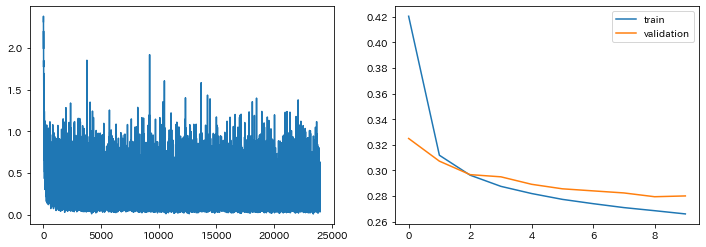

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(cnn.loss_list)
ax[1].plot(cnn.loss_epoch_list, label='train')
ax[1].plot(cnn.loss_val_epoch_list, label='validation')
ax[1].legend()
plt.show()

# 出力層のみと比較する

In [35]:
class NN:
    def __init__(self, epoch=10, verbose=True):
        self.epoch = epoch
        self.verbose = verbose
        self.layers = {}
        self.layers['Affine1'] =  FC(784, 10, XavierInitializer, AdaGrad)
        self.last_layer = SoftmaxWithLoss()

    def fit(self, X, y, X_val=None, y_val=None):
        self.loss_list = []
        self.loss_epoch_list = []
        self.loss_val_epoch_list = []
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20, seed=i)
            loss_tmp_list = []
            for X_batch, y_batch in get_mini_batch:
                for layer in self.layers.values():
                    X_batch = layer.forward(X_batch)
                softmax = self.last_layer.forward(X_batch)
                loss, dA = self.last_layer.backward(y_batch)
                self.loss_list.append(loss)
                loss_tmp_list.append(loss)
                layers = list(self.layers.values())
                layers.reverse()
                for layer in layers:
                    dA = layer.backward(dA)
                    
            epoch_mean_loss = np.mean(loss_tmp_list)
            self.loss_epoch_list.append(epoch_mean_loss)
            if self.verbose:
                print(epoch_mean_loss)
            if X_val is not None and y_val is not None:
                X_val_copy = X_val.copy()
                for layer in self.layers.values():
                    X_val_copy = layer.forward(X_val_copy)
                softmax_val = self.last_layer.forward(X_val_copy)
                loss_val = -np.sum(y_val*np.log(softmax_val + 1e-7))/y_val.shape[0]
                self.loss_val_epoch_list.append(loss_val)
            
    def predict(self, X):
        for layer in self.layers.values():
            X = layer.forward(X)
        self.last_layer.forward(X)
        y_pred = np.argmax(self.last_layer.softmax, axis=1)
        
        return y_pred

In [36]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [37]:
X_train = X_train.reshape(-1,  784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_tr.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

1.0
0.0
(60000,)
(60000, 10)
float64
(48000, 784)
(12000, 784)


In [38]:
nn = NN()

In [39]:
nn.fit(X_tr, y_tr, X_val, y_val)

0.4625188117344012
0.3539084911612489
0.3325796015092626
0.32105549441105247
0.3131286805325861
0.30751144208777365
0.30300485834457697
0.29939529410018945
0.2962448961660367
0.29373901439975775


In [40]:
y_pred_nn = nn.predict(X_val)
y_pred_nn

array([1, 2, 7, ..., 4, 6, 4], dtype=int64)

In [41]:
y_val_label = np.argmax(y_val, axis=1)
y_val_label

array([1, 2, 7, ..., 4, 6, 4], dtype=int64)

In [42]:
accuracy = accuracy_score(y_val_label, y_pred_nn)
print('accuracy_score:{}'.format(accuracy))

accuracy_score:0.9138333333333334


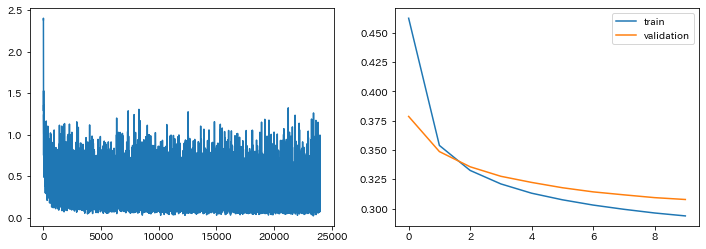

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(nn.loss_list)
ax[1].plot(nn.loss_epoch_list, label='train')
ax[1].plot(nn.loss_val_epoch_list, label='validation')
ax[1].legend()
plt.show()

## 畳み込み層を入れても入れなくても結果はほとんど変わらなかった。画像データの1次元の畳み込みだと横関係の特徴は反映されるが、縦関係の特徴が反映されないので、全結合層とあまり変わらなかったと考える。